In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path
try:
    from june.paths import camp_data_path
    data_path = camp_data_path
except:
    camp_data_path = data_path
from june import World
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.world import generate_world_from_hdf5
from june.distributors.camp_household_distributor import CampHouseholdDistributor
from june.groups import Households

No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
No --camp_data argument given - defaulting to:
/home/florpi/camps/JUNE/camp_data
No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs


In [5]:
from june.groups.leisure import PumpLatrines, PumpLatrineDistributor
from june.groups.leisure import DistributionCenters, DistributionCenterDistributor
from june.groups.leisure import Communals, CommunalDistributor

In [6]:
area_mapping_filename = camp_data_path / "input/geography/area_super_area_region.csv"
area_coordinates_filename = camp_data_path / "input/geography/area_coordinates.csv"
super_area_coordinates_filename = (
    camp_data_path / "input/geography/super_area_coordinates.csv"
)
age_structure_filename = (
    camp_data_path / "input/demography/age_structure_super_area.csv"
)
area_residents_families = (
    camp_data_path / "input/demography/area_residents_families.csv"
)
area_residents_families_df = pd.read_csv(area_residents_families)
area_residents_families_df.set_index("area", inplace=True)

## Initialize the world

In [7]:
%%time
geography = Geography.from_file(
    #filter_key={"region": ["CXB-210"]},
    filter_key=None,  # {"region": ["CXB-219"]},
    hierarchy_filename=area_mapping_filename,
    area_coordinates_filename=area_coordinates_filename,
    super_area_coordinates_filename=super_area_coordinates_filename,
)

2020-06-10 14:21:36,182 - june.demography.geography - INFO - There are 1385 areas and 112 super_areas in the world.
CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 283 ms


In [8]:
super_area_names = [super_area.name for super_area in geography.super_areas]
age_sex_generators = load_age_and_sex_generators_for_bins(age_structure_filename)

In [9]:
demography = Demography(
    age_sex_generators=age_sex_generators, area_names=super_area_names
)

In [10]:
world = World()
world.areas = geography.areas
world.super_areas = geography.super_areas
world.people = Population()

In [11]:
# populate area with generators from super areas
for super_area in world.super_areas:
    population = demography.populate(
        super_area.name, ethnicity=False, socioecon_index=False
    )
    np.random.shuffle(population.people)
    world.people.extend(population)
    total_residents_in_super_area = len(population)
    # create two lists to distribute even among areas
    adults = [person for person in population if person.age >= 17]
    kids = [person for person in population if person.age < 17]
    n_kids = len(kids)
    n_adults = len(adults)
    residents_data = {}
    total_residents = 0
    # note: the data that has age distributions and the data that has n_families does not match
    # so we need to do some rescaling
    for area in super_area.areas:
        residents_data[area.name] = area_residents_families_df.loc[area.name, "residents"]
        total_residents += residents_data[area.name]
    for area in super_area.areas:
        n_residents_data = residents_data[area.name]
        population_ratio = n_residents_data / total_residents 
        n_adults_area = int(
            np.round(population_ratio * n_adults)
        )
        n_kids_area = int(
            np.round(population_ratio * n_kids)
        )
        for _ in range(n_adults_area):
            if not adults:
                break
            area.add(adults.pop())
        for _ in range(n_kids_area):
            if not kids:
                break
            area.add(kids.pop())
    people_left = adults + kids
    if people_left:
        areas = np.random.choice(super_area.areas, size=len(people_left))
        for area in areas:
            area.add(people_left.pop())
    assert len([person for area in super_area.areas for person in area.people]) == total_residents_in_super_area

In [12]:
# household population
household_distributor = CampHouseholdDistributor(max_household_size=12)
households_total = []
for area in world.areas:
    area_data = area_residents_families_df.loc[area.name]
    n_families = int(area_data["families"])
    n_residents = int(area_data["residents"])
    n_families_adapted = int(np.round(len(area.people) / n_residents * n_families))
    area.households = household_distributor.distribute_people_to_households(
        area=area, n_families=n_families_adapted,
    )
    households_total += area.households
world.households = Households(households_total)

In [13]:
hospitals= Hospitals.from_file(
    filename=data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)
hospital_distributor.distribute_medics_from_world(world.people)


2020-06-10 14:21:51,081 - june.groups.hospital - INFO - There are 8 hospitals in the world.


In [14]:
world.pumplatrines = PumpLatrines.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_geography(geography)
world.communal = Communals.for_geography(geography)

## Geography exploration

### UNHCR camp blocks inside the World

In [15]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [16]:
super_areas[:5]

['CXB-232-B', 'CXB-232-C', 'CXB-232-G', 'CXB-203-C', 'CXB-207-D']

### Mahjee blocks inside World

In [17]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [18]:
areas[:5]

['CXB-232-002', 'CXB-232-001', 'CXB-232-008', 'CXB-232-006', 'CXB-203-039']

## Demography exploration

### UNHCR block residents

In [19]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [20]:
sample_sexes[:5], sample_ages[:5]

(['m', 'm', 'f', 'm', 'm'], [33, 27, 48, 50, 32])

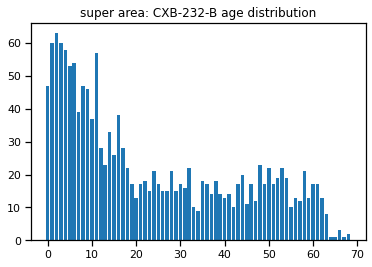

In [21]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [22]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 47.0%


## Activity exploration

### Pumps and latrines 

In [23]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pumplatrines:
    pumps_and_latrines.append(pump_latrine)

In [24]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 14 pumps and latrines in area CXB-232-002


### Distribution centers

In [25]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [26]:
distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### Communal spaces

In [27]:
communal_spaces = []
for space in world.communal:
    communal_spaces.append(space)

In [28]:
communal_spaces[0].coordinates

array([21.19588, 92.152  ])